In [31]:
from os import path 

from keras.layers import Input
from keras.models import Model

import numpy as np

import blusky.datasets as datasets
from blusky.transforms.apply_father_wavelet_2d import ApplyFatherWavlet2D
from blusky.transforms.cascade_2d import Cascade2D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.default_decimation import DefaultDecimation
from blusky.utils.pad_2d import Pad2D, pad_to_log2
from blusky.wavelets.wavelet_factories_2d import vanilla_gabor_2d, vanilla_morlet_2d

In [32]:
test_file_1 = path.join(
    path.dirname(datasets.__file__), "twod_image_1.npy")

original_image = np.load(test_file_1)
original_shape = original_image.shape

img = pad_to_log2(original_image)
img = np.expand_dims(img, axis=-1)

dh = img.shape[0] - original_shape[0]
dw = img.shape[1] - original_shape[1]

In [33]:
dh

24

(232, 476)
(256, 512, 1)


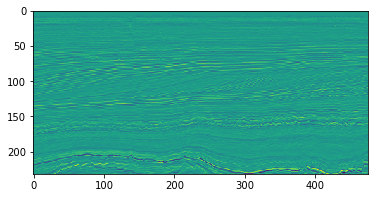

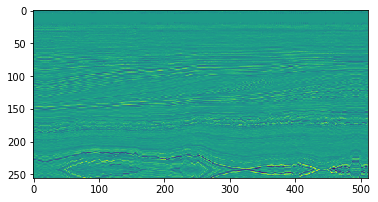

In [12]:
%matplotlib inline
import pylab as plt

print(original_shape)
print(img.shape)
plt.imshow(original_image)
plt.show()
plt.imshow(img[:,:,0])

In [13]:
# Don't make this too huge for brevity.
J = 3
# 0 = no overlap etc.
overlap_log_2 = 3
# apply to all available orders
order = J
# Should be one or more to avoid aliasing, if you want overlapping tiles, 
# this can increase too.
oversampling = 2 

angles=(0.0, 45., 90., 135.)


# details of the input data
img_size = img.shape
sample_rate = 0.004*3

# vanilla filter bank
wavelets = [vanilla_morlet_2d(sample_rate, j=i) for i in range(0,J)]
father_wavelet = vanilla_gabor_2d(sample_rate, j=J)
print (father_wavelet.kernel(0.).shape)
# method of decimation
deci = DefaultDecimation(oversampling=oversampling)

# input
inp = Input(shape=img.shape)

# valid padding
cascade2d = Cascade2D("none", 
                    0, 
                    decimation=deci,
                    angles=angles)

# Pad the input
pad_2d = Pad2D(wavelets, decimation=deci)
padded = pad_2d.pad(inp)

# Apply cascade with successive decimation
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, cascade2d._convolve)
convs = cascade_tree.get_convolutions()

# Create layers to remove padding
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, pad_2d._unpad_same)
unpad = cascade_tree.get_convolutions()

# Remove the padding
unpadded_convs = [i[1](i[0]) for i in zip(convs, unpad)]

# Complete the scattering transform with the father wavelet
apply_conv = ApplyFatherWavlet2D(J=J, overlap_log_2=overlap_log_2, 
                              img_size=img.shape, sample_rate=sample_rate,
                              wavelet=father_wavelet)

sca_transf = apply_conv.convolve(unpadded_convs)

W1008 09:14:39.773349 4564235712 deprecation_wrapper.py:119] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1008 09:14:39.819759 4564235712 deprecation_wrapper.py:119] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 09:14:39.871497 4564235712 deprecation.py:323] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:2618: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


(31, 31)


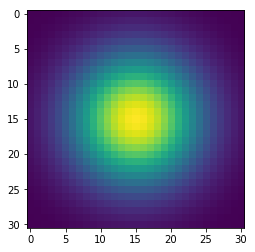

In [30]:
fw = father_wavelet.kernel(0.)

plt.imshow(np.real(fw))

In [14]:
model = Model(inputs=inp, outputs=sca_transf)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 512, 1)  0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 288, 544, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
depthwise_conv2d_1 (DepthwiseCo (None, 288, 544, 4)  200         reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_2 (DepthwiseCo (None, 288, 544, 4)  200         reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
lambda_1 (

In [15]:
result = model.predict(np.expand_dims(img, axis=0))

W1008 09:17:01.764509 4564235712 deprecation_wrapper.py:119] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1008 09:17:01.768599 4564235712 deprecation_wrapper.py:119] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1008 09:17:01.770789 4564235712 deprecation_wrapper.py:119] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [16]:
from cv2 import resize
import matplotlib.pylab as plt

dh2 = dh//2
dw2 = dw//2

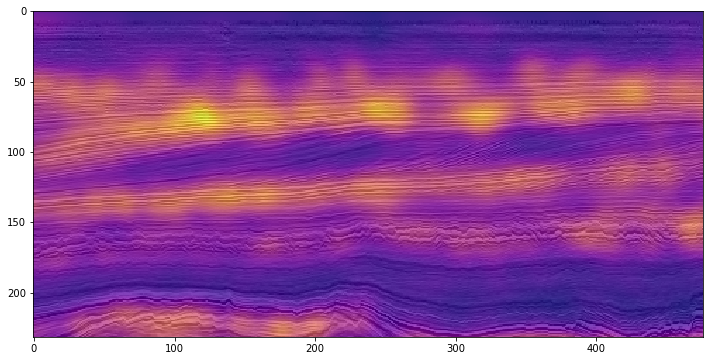

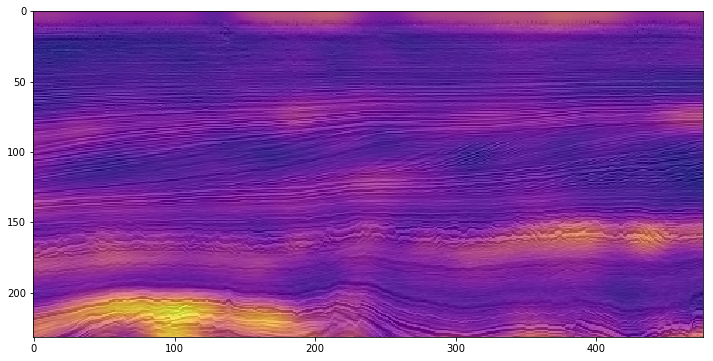

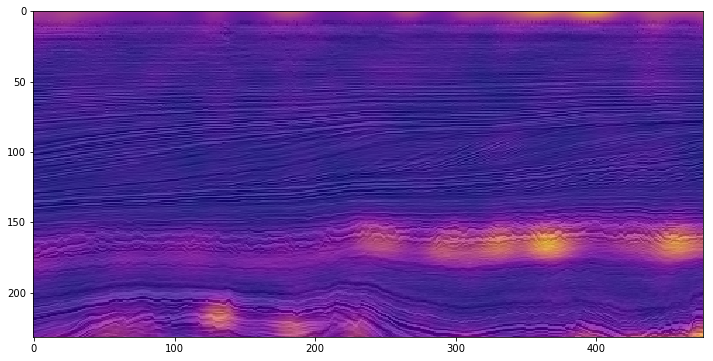

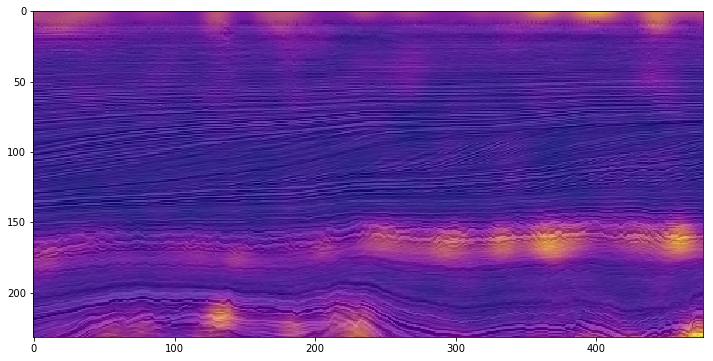

In [17]:
i = 2

_img = resize(result[0][0,:,:,i], (img.shape[1], img.shape[0]))
plt.figure(figsize=(12,6))
plt.imshow(img[dh2:-dh2,dw2:-dw2,0], cmap='gray', vmin=-2.0*np.std(img), vmax=2.0*np.std(img))
plt.imshow(_img[dh2:-dh2,dw2:-dw2], alpha=0.75, cmap='plasma')
plt.show()

_img = resize(result[2][0,:,:,i], (img.shape[1], img.shape[0]))
plt.figure(figsize=(12,6))
plt.imshow(img[dh2:-dh2,dw2:-dw2,0], cmap='gray', vmin=-2.0*np.std(img), vmax=2.0*np.std(img))
plt.imshow(_img[dh2:-dh2,dw2:-dw2], alpha=0.75, cmap='plasma')
plt.show()

_img = resize(result[4][0,:,:,i], (img.shape[1], img.shape[0]))
plt.figure(figsize=(12,6))
plt.imshow(img[dh2:-dh2,dw2:-dw2,0], cmap='gray', vmin=-2.0*np.std(img), vmax=2.0*np.std(img))
plt.imshow(_img[dh2:-dh2,dw2:-dw2], alpha=0.75, cmap='plasma')
plt.show()


_img = resize(result[3][0,:,:,i], (img.shape[1], img.shape[0]))
plt.figure(figsize=(12,6))
plt.imshow(img[dh2:-dh2,dw2:-dw2,0], cmap='gray', vmin=-2.0*np.std(img), vmax=2.0*np.std(img))
plt.imshow(_img[dh2:-dh2,dw2:-dw2], alpha=0.75, cmap='plasma')
plt.show()


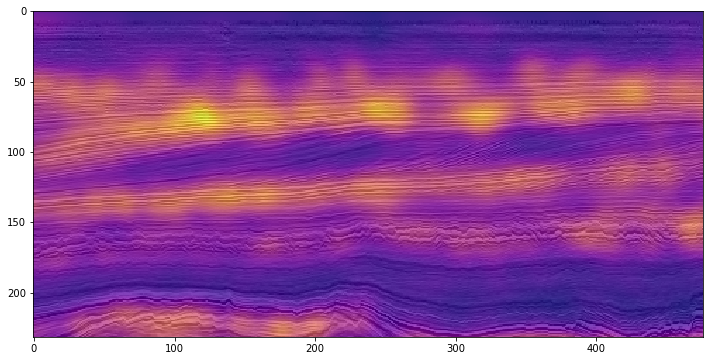

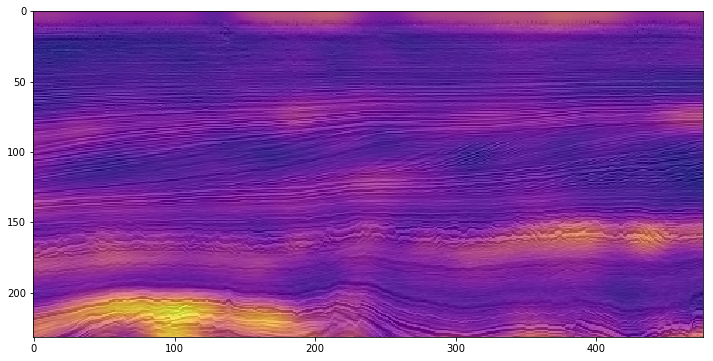

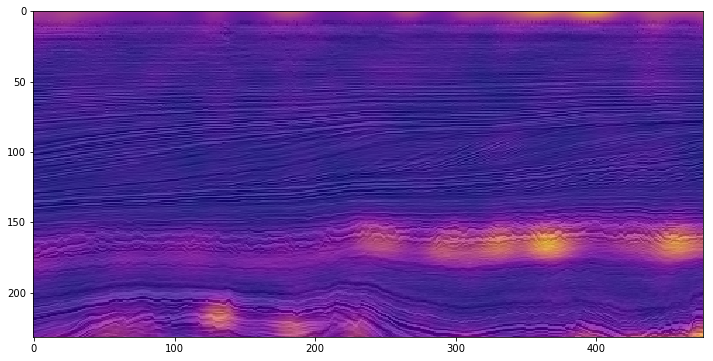

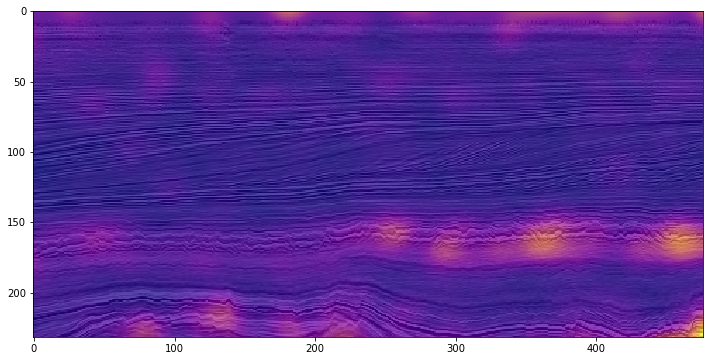

In [163]:


_img = resize(result[0][0,:,:,2], (img.shape[1], img.shape[0]))
plt.figure(figsize=(12,6))
plt.imshow(img[dh2:-dh2,dw2:-dw2,0], cmap='gray', vmin=-2.0*np.std(img), vmax=2.0*np.std(img))
plt.imshow(_img[dh2:-dh2,dw2:-dw2], alpha=0.75, cmap='plasma')
plt.show()

_img = resize(result[2][0,:,:,2], (img.shape[1], img.shape[0]))
plt.figure(figsize=(12,6))
plt.imshow(img[dh2:-dh2,dw2:-dw2,0], cmap='gray', vmin=-2.0*np.std(img), vmax=2.0*np.std(img))
plt.imshow(_img[dh2:-dh2,dw2:-dw2], alpha=0.75, cmap='plasma')
plt.show()

_img = resize(result[4][0,:,:,2], (img.shape[1], img.shape[0]))
plt.figure(figsize=(12,6))
plt.imshow(img[dh2:-dh2,dw2:-dw2,0], cmap='gray', vmin=-2.0*np.std(img), vmax=2.0*np.std(img))
plt.imshow(_img[dh2:-dh2,dw2:-dw2], alpha=0.75, cmap='plasma')
plt.show()


_img = resize(result[6][0,:,:,2], (img.shape[1], img.shape[0]))
plt.figure(figsize=(12,6))
plt.imshow(img[dh2:-dh2,dw2:-dw2,0], cmap='gray', vmin=-2.0*np.std(img), vmax=2.0*np.std(img))
plt.imshow(_img[dh2:-dh2,dw2:-dw2], alpha=0.75, cmap='plasma')
plt.show()
